In [ ]:
!pip install adjustText

In [32]:
import json
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from adjustText import adjust_text
deps = ['gpe', 'locations', 'norps', 'organisations', 'people']

# prepairing data for visualization

The following function extracts top-20 words from each NER category and sorts them depending on their frequency

In [ ]:
def get_20(data, deps, it, year):
  deps = deps[:20]
  for dep in deps:
    dep[2] = dep[2][:100]
    dep[3] = dep[3][:100]
    dep[4] = dep[4][:100]
    dep[5] = dep[5][:100]
    dep[6] = dep[6][:100]
  data[f'{year}_{it}'] = deps
  return data

In [ ]:
for dep in deps:
  data = {}
  for it in range(1, 13):
    with open(f'final_{dep}_1904_{it}.json', 'r', encoding='utf-8') as json_file:
      final_data = json.load(json_file)
    data = get_20(data, final_data, it, 1904)
  with open(f'data_{dep}_1904.json', 'w') as file:
    json.dump(data, file)

# visualizing ner frequency data

The function get_top_5 extracts top-5 words for each NER category for each month

In [ ]:
def get_top_5(ners):
  data = {}
  for ner in ners:
    top_words = [(word[0], word[1]) for word in ners[ner][:5]]
    data[ner] = top_words
  return data

The following function creates a pandas df with frequencies of each word, that occures in top-5 at least once a year

In [ ]:
def get_top_ners(data):
  all_words = set()
  for month in data.keys():
    all_words.update([word for word, freq in data[month]])
  all_words = sorted(all_words)

  months = list(data.keys())
  df = pd.DataFrame(index=all_words, columns=months)

  for month, words in data.items():
    for word, freq in words:
      df.loc[word, month] = freq
  return df

The following function builds stacked histogram charts for top-5 words of selected NER type for each month of the year

In [ ]:
def build_ner_stats(df, ner_tag, year):
  plt.figure(figsize=(12, 6))
  colors = sns.color_palette("coolwarm", len(df))
  months = df.columns
  words = df.index

  bottom = np.zeros(len(months))

  for i, word in enumerate(words):
    frequencies = df.loc[word]
    plt.bar(months,
            frequencies,
            bottom=bottom,
            label=word,
            color=colors[i])

    for j, (month, freq) in enumerate(zip(months, frequencies)):
      if not pd.isna(freq) and freq > 0:
        y_pos = bottom[j] + freq / 2
        plt.text(x=j,
                 y=y_pos,
                 s=round(freq, 1),
                 ha='center',
                 va='center',
                 color='navy',
                 fontsize=8)
    bottom += frequencies.fillna(0)

  plt.title(f"Динамика частотности {ner_tag} сущностей по месяцам за {year} год")
  plt.legend(bbox_to_anchor=(1.05, 1))
  plt.grid(axis='y')
  plt.tight_layout()
  plt.savefig(f'graph_{ner_tag}_{year}.png')
  plt.show()

In [ ]:
def get_stats(file_1, file_2, ner_tag):
  with open(file_1, 'r', encoding='utf-8') as json_file:
    deps_1904 = json.load(json_file)
  with open(file_2, 'r', encoding='utf-8') as json_file:
    deps_1905 = json.load(json_file)
  data_1904 = get_top_5(deps_1904)
  data_1905 = get_top_5(deps_1905)

  ners_1904 = get_top_ners(data_1904)
  ners_1905 = get_top_ners(data_1905)

  build_ner_stats(ners_1904, ner_tag, '1904')
  build_ner_stats(ners_1905, ner_tag, '1905')

In [ ]:
get_stats('data_gpe_1904.json', 'data_gpe_1905.json', 'GPE')

# prepairing pos frequency data

The following function selects 20 most frequent parts of speech for each month in data

In [ ]:
def get_pos_stats(file, ner):
  with open(file, 'r', encoding='utf-8') as json_file:
    stats = json.load(json_file)
  data = {}
  for el in stats.keys():
    data[el] = {'nouns': [],
                        'verbs': [],
                        'adjs': [],
                        'advbs': []}
    for word in stats[el]:
      if word[0] == ner:
        data[el]['nouns'] = word[2][:20]
        data[el]['verbs'] = word[3][:20]
        data[el]['adjs'] = word[5][:20]
        data[el]['advbs'] = word[6][:20]
  return data

In [ ]:
japan_1904 = get_pos_stats('data_gpe_1904.json', 'japan')
japan_1905 = get_pos_stats('data_gpe_1905.json', 'japan')
russia_1904 = get_pos_stats('data_gpe_1904.json', 'russia')
russia_1905 = get_pos_stats('data_gpe_1905.json', 'russia')

These are the months for filtering data

In [ ]:
keys_1904 = ['1903_12', '1904_2', '1904_5', '1904_8', '1904_12']
keys_1905 = ['1905_1', '1905_3', '1905_8', '1905_12']

The following function sorts data according to selected months

In [ ]:
def filter_months(data, months):
  data_filtered = {}
  for key in data.keys():
    if key in months:
      data_filtered[key] = data[key]
  return data_filtered

In [ ]:
jp_filtered_1904 = filter_months(japan_1904, keys_1904)
ru_filtered_1904 = filter_months(russia_1904, keys_1904)
jp_filtered_1905 = filter_months(japan_1905, keys_1905)
ru_filtered_1905 = filter_months(russia_1905, keys_1905)

The following functions convert data to dataframes

In [ ]:
def dict_to_df(data_dict, country_name):
  rows = []
  for pos, words_freqs in data_dict.items():
    for word, freq in words_freqs:
      rows.append({'word': word, 'pos-tag': pos, f'{country_name}_tokens': freq})
  return pd.DataFrame(rows)

In [ ]:
def get_frequencies(data1, data2, key):
  df1 = dict_to_df(data1[key],'japan')
  df2 = dict_to_df(data2[key], 'russia')
  result = pd.merge(df1, df2, on=['word', 'pos-tag'], how='outer')
  return result

In [ ]:
for i in range(len(keys_1904)):
  key = keys_1904[i]
  result = get_frequencies(jp_filtered_1904, ru_filtered_1904, key)
  result.to_csv(f'pos_freqs_{key}.csv')

for i in range(len(keys_1905)):
  key = keys_1905[i]
  result = get_frequencies(jp_filtered_1905, ru_filtered_1905, key)
  result.to_csv(f'pos_freqs_{key}.csv')

# visualizing frequencies

The following function builds bubble charts for part of speech distribution for japan and russia for each selected month

In [29]:
def build_bubble_chart(file, date):
  df = pd.read_csv(file).fillna(0)
  df["category"] = np.where(
    (df["russia_tokens"] > 0) & (df["japan_tokens"] > 0), "both",
    np.where(df["russia_tokens"] > 0, "russia", "japan"))
  df["size"] = df["russia_tokens"] + df["japan_tokens"]

  colors = {"both": "green", "russia": "blue", "japan": "red"}


  parts_of_speech = {"nouns": (0, 0, "Nouns"),
                     "verbs": (0, 1, "Verbs"),
                     "adjs": (1, 0, "Adjectives"),
                     "advbs": (1, 1, "Adverbs")
                     }

  fig, axs = plt.subplots(2, 2, figsize=(15, 12))
  fig.suptitle("Частотность слов по частям речи", fontsize=16, y=1.02)

  for pos, (row, col, title) in parts_of_speech.items():
    ax = axs[row, col]
    subset = df[df["pos-tag"] == pos]

    for category, color in colors.items():
      mask = subset["category"] == category
      ax.scatter(subset.loc[mask, "russia_tokens"],
                 subset.loc[mask, "japan_tokens"],
                 s=subset.loc[mask, "size"]/3,
                 c=color,
                 alpha=0.7,
                 edgecolor="black",
                 linewidth=0.5,
                 label=category)

    ax.set_title(title, fontsize=12)
    ax.set_xlabel("Распределения в упоминаниях России", fontsize=9)
    ax.set_ylabel("Распределения в упоминаниях Японии", fontsize=9)
    ax.grid(alpha=0.2)

    texts = []
    for _, row in subset[subset["size"] > subset["size"].quantile(0.5)].iterrows():
      texts.append(ax.text(
          row["russia_tokens"], row["japan_tokens"], row["word"],
          fontsize=8, ha='center', va='center'
      ))

    adjust_text(texts, ax=ax,
              arrowprops=dict(arrowstyle='-', color='gray', lw=0.3),
              expand_points=(1.2, 1.2))

  handles, labels = axs[0,0].get_legend_handles_labels()
  fig.legend(handles, labels,
            bbox_to_anchor=(1.02, 0.9), loc="upper left")

  plt.tight_layout()
  plt.savefig(f'chart_{date}.png')
  plt.show()

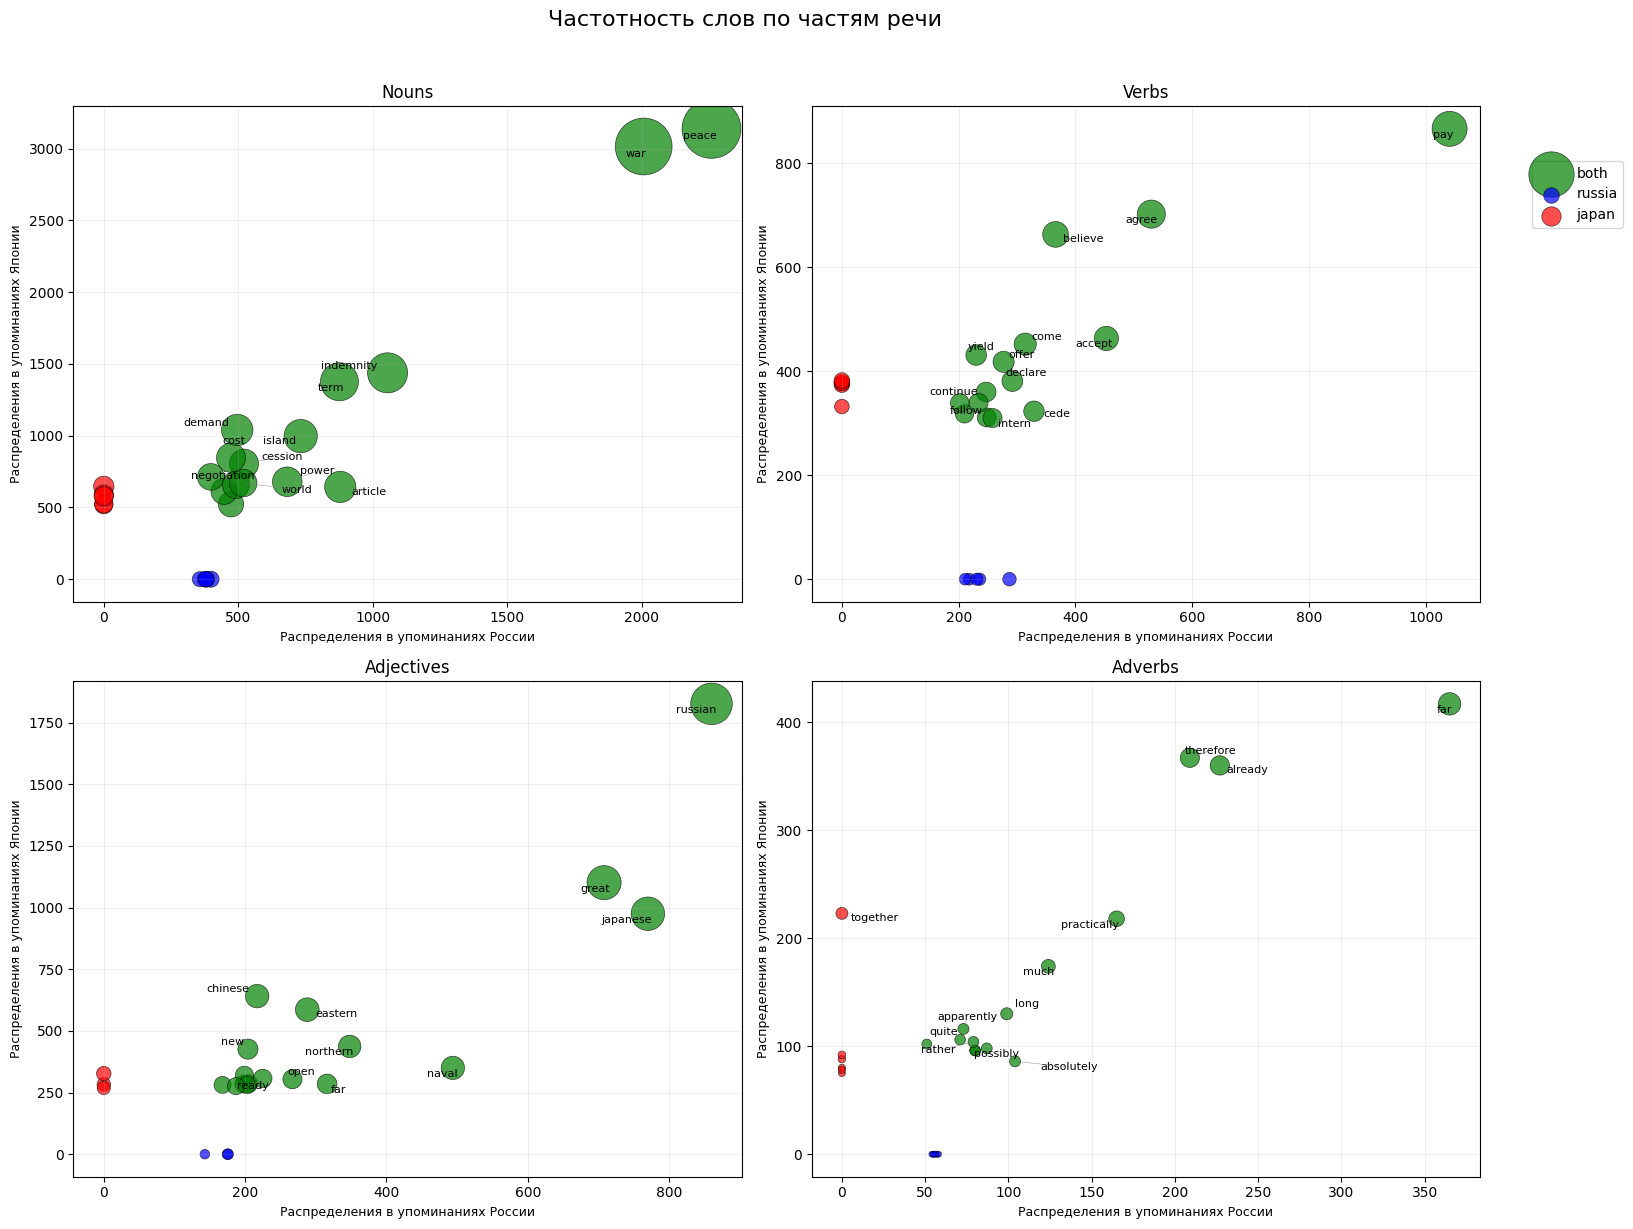

In [30]:
build_bubble_chart('pos_freqs_1905_8.csv', '1905_8')

# visualizing sentiment data

The following functions allow to visualize results of sentiment analysis and save graphs into corresponding files.

In [ ]:
def clean_data(file):
  data = pd.read_csv(file)
  data = data.rename(columns={'Unnamed: 0': 'date'})
  return data

In [ ]:
japan = clean_data('japan_1905.csv')
russia = clean_data('russia_1905.csv')

In [ ]:
def build_sentiment_graph(data_1, data_2, year):
  fig, ax = plt.subplots()
  fig.set_size_inches(12, 6)
  ax.set_ylim(0, 25000)
  plt.plot(data_1['date'], data_1['positive'],
         label='Позитивные (Япония)', marker='o', color='black')
  plt.plot(data_1['date'], data_1['negative'],
          label='Негативные (Япония)', marker='o', color='grey')
  plt.plot(data_2['date'], data_2['positive'],
          label='Позитивные (Россия)', marker='o', color='blue')
  plt.plot(data_2['date'], data_2['negative'],
          label='Негативные (Россия)', marker='o', color='lightblue')

  max_value_jp = max(data_1['positive'].max(), data_1['negative'].max())
  offset_jp = max_value_jp * 0.03
  max_value_ru = max(data_2['positive'].max(), data_2['negative'].max())
  offset_ru = max_value_ru * 0

  for i in range(len(data_1)):
    month = data_1['date'].iloc[i]
    pos = data_1['positive'].iloc[i]
    neg = data_1['negative'].iloc[i]
    total = pos + neg

    pos_pct_jp = (pos / total * 100)
    neg_pct_jp = (neg / total * 100)

    plt.text(month, pos + offset_jp, f'{round(pos_pct_jp, 1)}%',
              ha='center', va='bottom',
              color='black', fontsize=8,
              bbox=dict(facecolor='white',edgecolor='none', pad=1))

    plt.text(month, neg + offset_jp, f'{round(neg_pct_jp, 1)}%',
              ha='center', va='bottom',
              color='black', fontsize=8,
              bbox=dict(facecolor='white',edgecolor='none', pad=1))

  for i in range(len(data_2)):
    month = data_2['date'].iloc[i]
    pos = data_2['positive'].iloc[i]
    neg = data_2['negative'].iloc[i]
    total = pos + neg

    pos_pct_ru = (pos / total * 100)
    neg_pct_ru = (neg / total * 100)

    plt.text(month, pos + offset_ru, f'{round(pos_pct_ru, 1)}%',
              ha='center', va='bottom',
              color='black', fontsize=8,
              bbox=dict(facecolor='white', edgecolor='none', pad=1))

    plt.text(month, neg + offset_ru, f'{round(neg_pct_ru, 1)}%',
              ha='center', va='bottom',
              color='black', fontsize=8,
              bbox=dict(facecolor='white', edgecolor='none', pad=1))

  plt.title(f'Динамика эмоциональной окраски новостей относительно Японии и России в {year} году по месяцам')
  plt.xlabel('Дата')
  plt.legend()
  plt.grid(True)
  plt.savefig(f'sentiments_{year}.png')
  plt.show()

In [ ]:
build_sentiment_graph(japan, russia, 1905)